# Demo

Import libraries

In [1]:
import src.isthmuslib as isli
import numpy as np
import pandas as pd
from typing import List, Dict, Callable
import pathlib
from matplotlib import cycler
from copy import deepcopy

Disable scrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Make up some random sample data

In [3]:
normal_randomness: Callable[[], np.ndarray] = lambda: np.random.normal(size=1000)
np.random.seed(0)
data_1: np.ndarray = normal_randomness()
data_2: np.ndarray = [1 + x / 2 for x in data_1]
data_3: np.ndarray = normal_randomness()
data_4: np.ndarray = normal_randomness()

# Visualize 1D Histogram

Single distribution

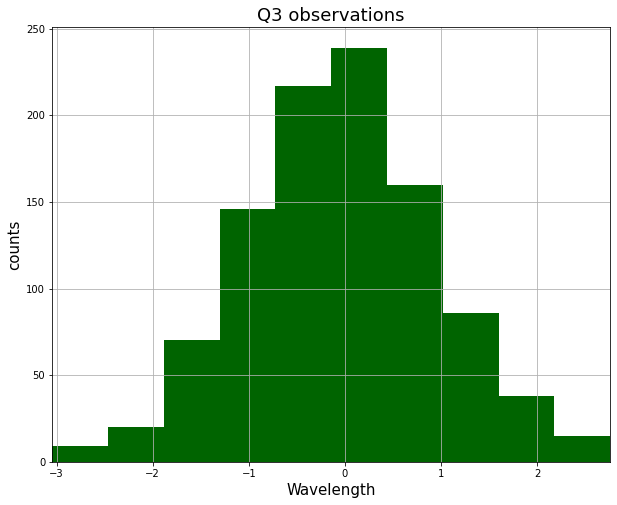

In [4]:
isli.hist(data_1, xlabel='Wavelength', title='Q3 observations');

Optionally we can define an isthmuslib Style object that can be passed to every plotting method for consistent results. Next line shows how to define a custom cycler, for example

In [5]:
style: isli.Style = isli.Style(cycler=(cycler(color=['r', 'g', 'b', 'y']) + cycler(linestyle=['-', '--', ':', '-.'])))

We can feed multiple distributions to `hist()`

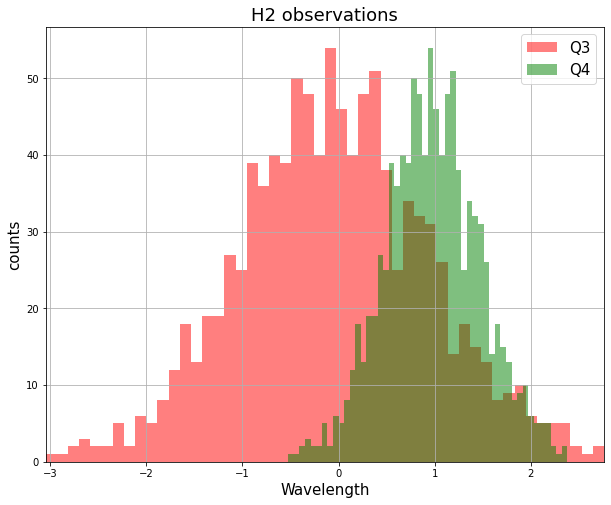

In [6]:
isli.hist([data_1, data_2], xlabel='Wavelength', title='H2 observations', legend_strings=["Q3", "Q4"], bins=50,
          style=style);

We can add any `matplotlib.pyplot.hist()` kwargs, e.g. `density` and `cumulative` and `bins`. Note that the y-axis label automatically updates to convey such adjustments.

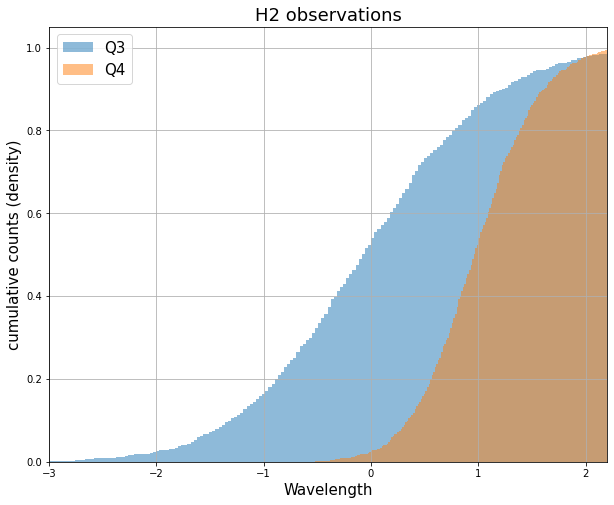

In [7]:
isli.hist([data_1, data_2], xlabel='Wavelength', title='H2 observations', legend_strings=["Q3", "Q4"], bins=200,
          density=True, cumulative=True, xlim=(-3, 2.2));

## Visualize 2D x & y

Scattering one data set. Note that the isthmuslib convention for log axes has been updated. Now provide a `log_axes` keyword argument, which can be a string (e.g. `''`, `x`, `y` or `xy`) or a list of strings (e.g. `[]`, `['x']`, `['y']`, or `['x', 'y']`)

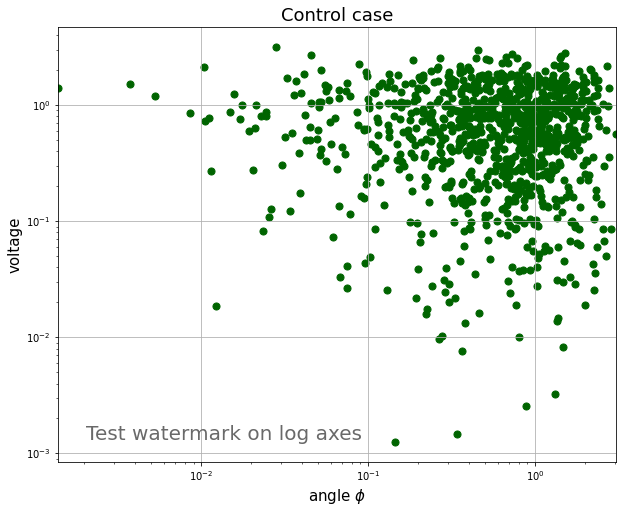

In [8]:
list_abs = lambda x: list(map(abs, x))
isli.scatter(list_abs(data_1), list_abs(data_3), log_axes='yx', xlabel='angle $\phi$', ylabel='voltage', title='Control case',
             watermark='Test watermark on log axes');

Multiple data sets version 1: `[x1, x2, ..., xN], [y1, y2, ..., yN]`

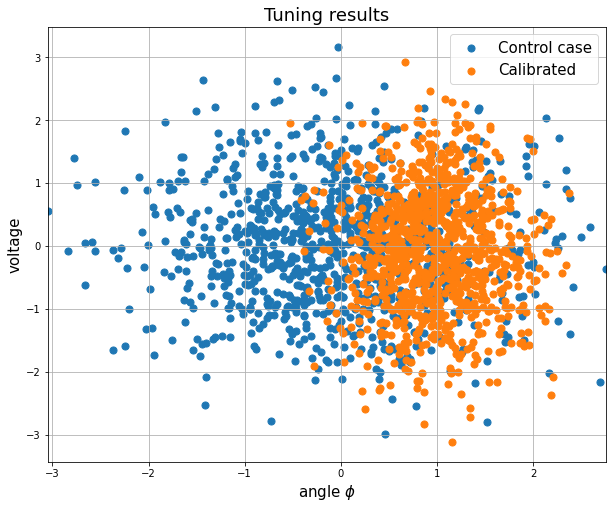

In [9]:
default_cycler = (cycler(color=['r', 'g', 'b', 'y']) +
                  cycler(linestyle=['-', '--', ':', '-.']))
style: isli.Style = isli.Style(cycler=default_cycler)
isli.scatter([data_1, data_2], [data_3, data_4], xlabel='angle $\phi$', ylabel='voltage', title='Tuning results',
             legend_strings=['Control case', 'Calibrated'],
             style=None);

Multiple data sets version 2: `[[x1, y1], [x2, y2], ..., [xN, yN]]`

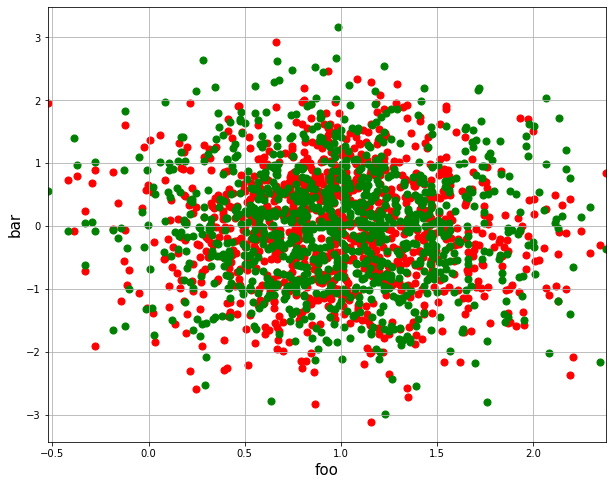

In [10]:
isli.scatter([[data_2, data_4], [data_2, data_3]], xlabel='foo', ylabel='bar', style=style);

Note that we can get the same plot by feeding in a single x array and multiple y's

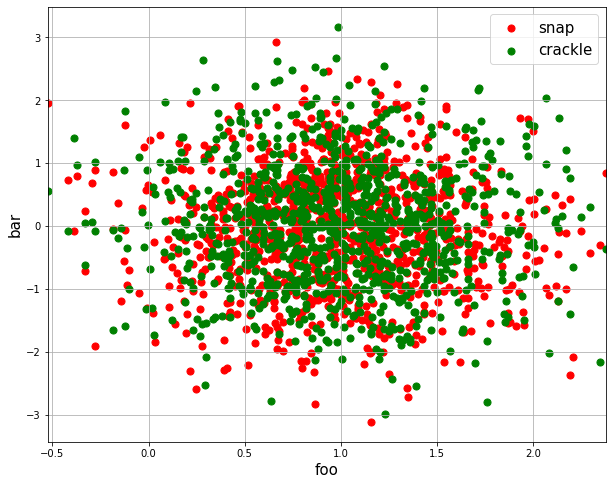

In [11]:
isli.scatter(data_2, [data_4, data_3], xlabel='foo', ylabel='bar', style=style, legend_strings=['snap','crackle']);

Above we see data vectors passed directly into `scatter()` but another options is providing 3 keyword arguments: a data frame, the name of the x axis column, and the name of the y-axism column. Note again that axes labels are added by default if not specified (y-axis).

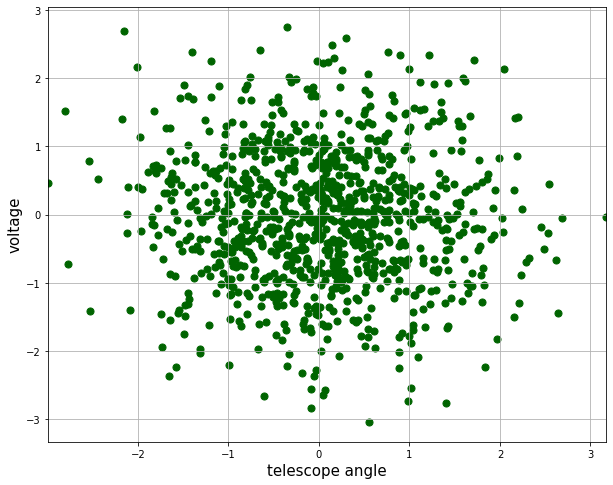

In [12]:
df: pd.DataFrame = pd.DataFrame({'voltage':data_1, 'angle':data_3})
isli.scatter(df, 'angle', 'voltage', xlabel='telescope angle');

We can also cast a single x & y vector pair into a 2D histogram (essentially a surface with height [color] showing bin counts)

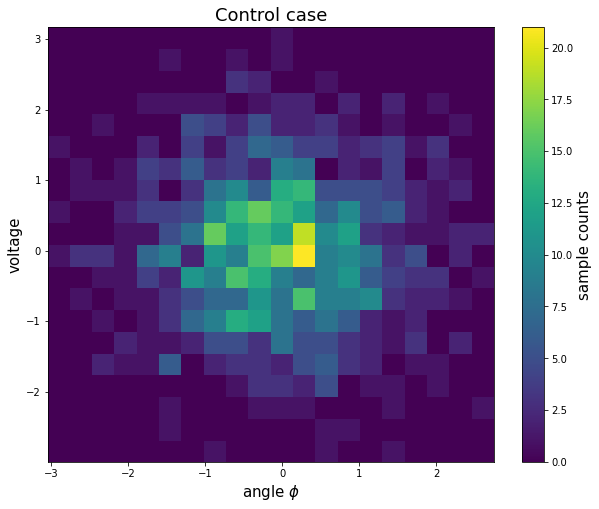

In [13]:
isli.hist2d(data_1, data_3, xlabel='angle $\phi$', ylabel='voltage', title='Control case', bins=(20, 20),
            colorbar_label='sample counts');

### Plotting surfaces

To-do: add some demos for plotting surfaces

## Working with Vector Sequences

The timeseries-like `VectorSequence` class has `.read_csv()` method for easy import (don't forget to set the `basis_col_name`)



In [14]:
timeseries: isli.VectorSequence = isli.VectorSequence().read_csv(
    pathlib.Path.cwd() / 'data' / 'version_controlled' / 'example_vector_sequence_data.csv', inplace=False,
    basis_col_name='timestamp', name_root='Experiment gamma')


The data is stored in a dataframe, so any pandas style calls and commands are available, for example:

In [15]:
timeseries.data.sort_values(by='foo', ascending=True, inplace=False).head(15)

,timestamp,foo,bar,baz
112,1578034800,0.05380,0.038067,0.05024
97,1576652400,0.05460,0.039700,0.04852
110,1577862000,0.05650,0.040167,0.04820
111,1577948400,0.05665,0.036333,0.04536
115,1578294000,0.05715,0.041900,0.05028
114,1578207600,0.05735,0.038233,0.04800
99,1576825200,0.05800,0.039600,0.04800
113,1578121200,0.05815,0.038033,0.04652
118,1578553200,0.05830,0.038600,0.04800
119,1578639600,0.05850,0.039633,0.04756


Plotting methods in the above style are attached to the timeseries itself. If we call that object's `.plot()` or `.hist()` (etc) methods, it will automatically create consistently styled and labeled plots

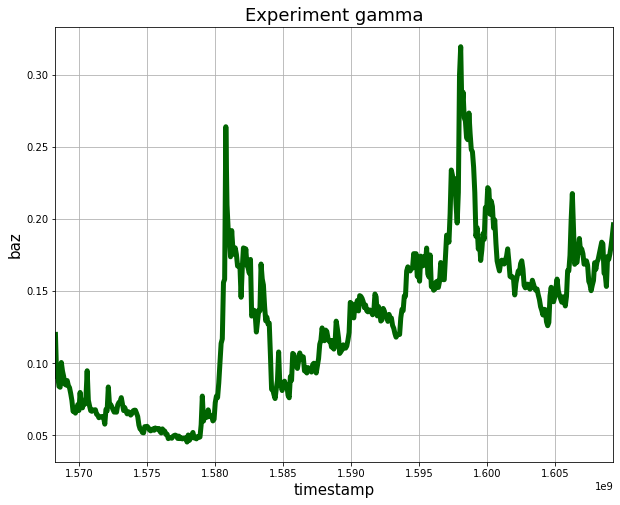

In [16]:
timeseries.plot('baz');

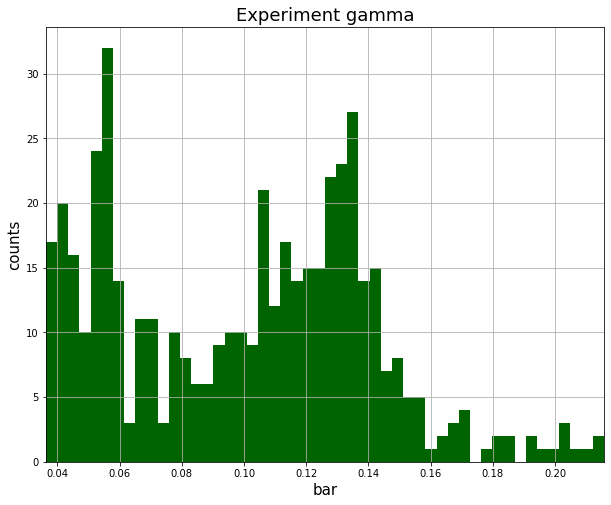

In [17]:
timeseries.hist('bar', bins=50);

### Seasonal decomposition

We can visualize seasonal decomposition analyses with a single line, wrapping `statsmodel.tsa`

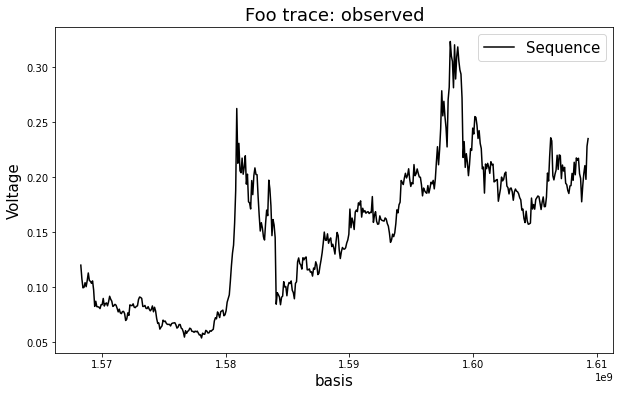

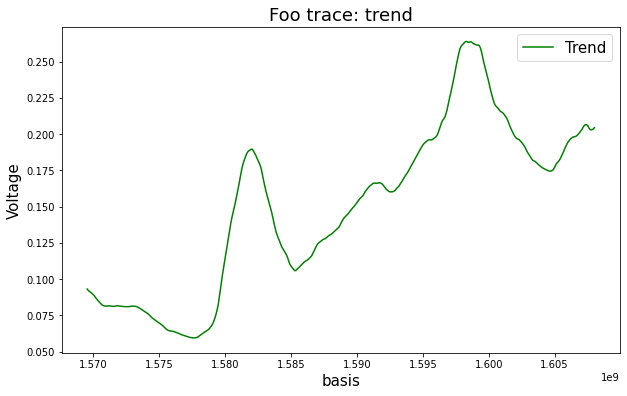

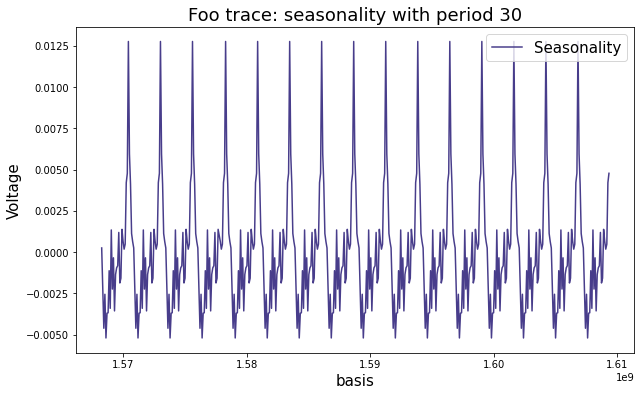

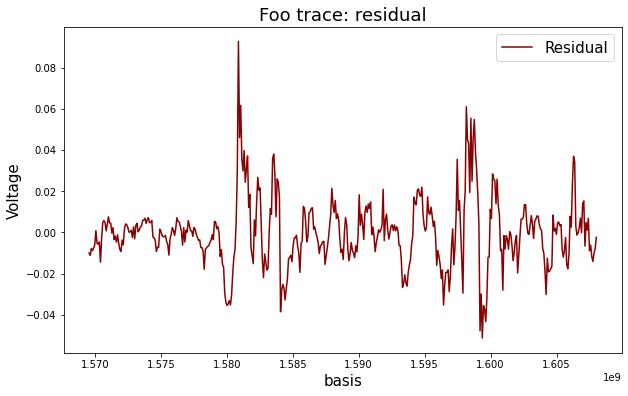

In [18]:
timeseries.plot_decomposition('foo', 30, figsize=(10, 6), title='Foo trace: ', ylabel='Voltage');

### Sliding window analyses

The VectorSequence timeseries class contains logic for sliding window analyses with arbitrary functions. Here we'll use a throwaway lambda `appreciation` to demonstrate

In [19]:
appreciation = lambda o: {'Change in value (%)': 100 * (o.values('foo')[-1] / o.values('foo')[0] - 1)}

Apply the function over sliding windows with 2, 4, and 8 week durations

In [20]:
window_widths_weeks: List[float] = [2, 4, 8]
result: isli.SlidingWindowResults = timeseries.sliding_window(appreciation,
                                                              [x * 60 * 60 * 24 * 7 for x in window_widths_weeks],
                                                              overlapping=True)

The `SlidingWindowResult.plot_results()` method automatically plots results separated by window width

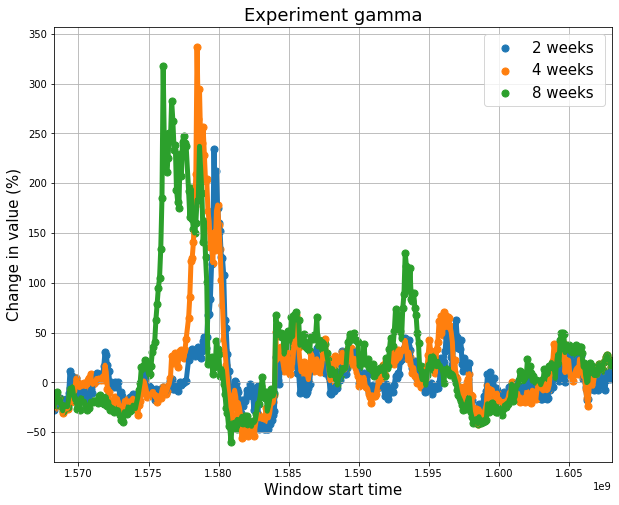

In [21]:
f = result.plot_results('Change in value (%)', legend_override=[f"{x} weeks " for x in window_widths_weeks]);

Likewise, the `sliding_window.plot_pdfs()` method plots distributions separated by window width

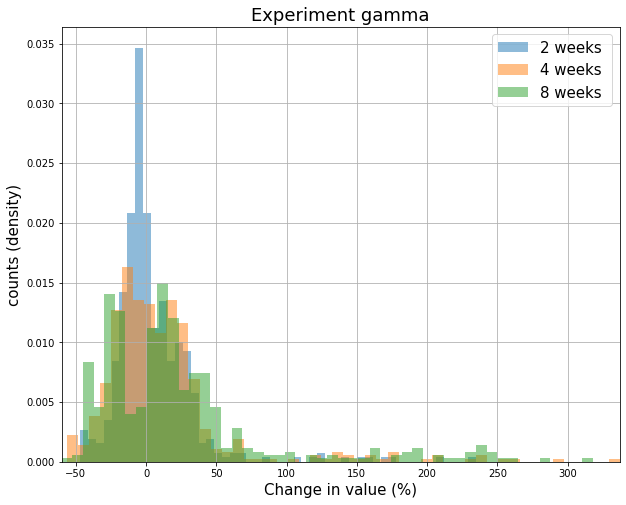

In [22]:
result.plot_pdfs('Change in value (%)', density=True, bins=50,
                 legend_override=[f"{x} weeks " for x in window_widths_weeks]);

Adding `cumulative=True` produces the CDF

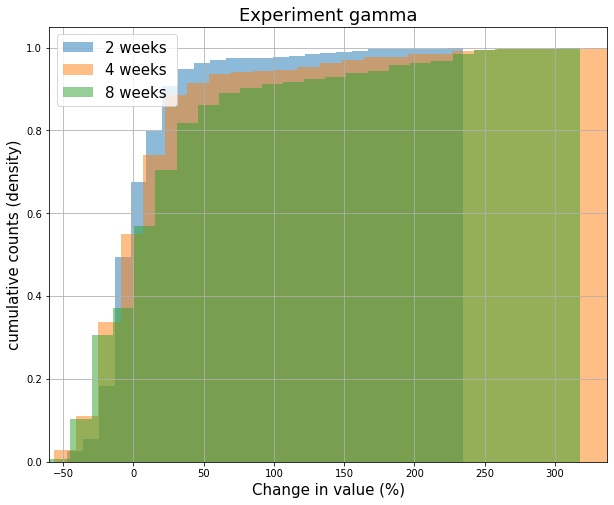

In [23]:
result.plot_pdfs('Change in value (%)', density=True, cumulative=True, bins=25,
                 legend_override=[f"{x} weeks " for x in window_widths_weeks]);

## Dimensionality reduction and information content analyses

Dimensionality reduction (SVD) logic over sliding windows is built into the `VectorSequence` class, allowing easy calculation and visualization of information surfaces (first 3 singular value surfaces shown below)

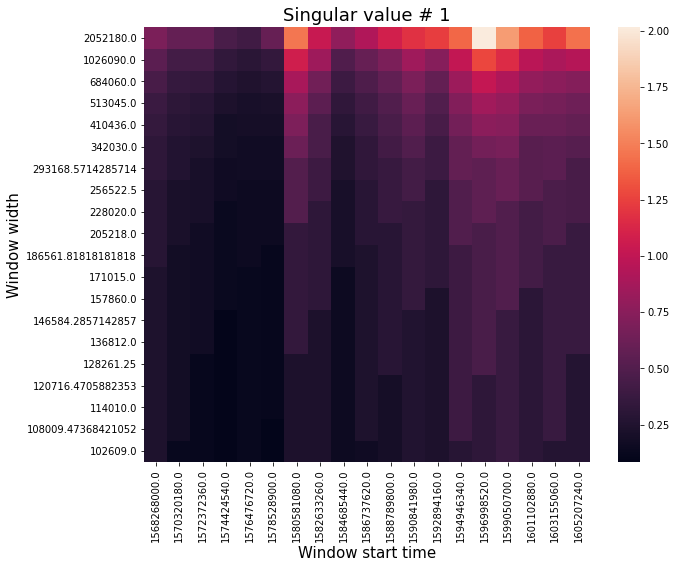

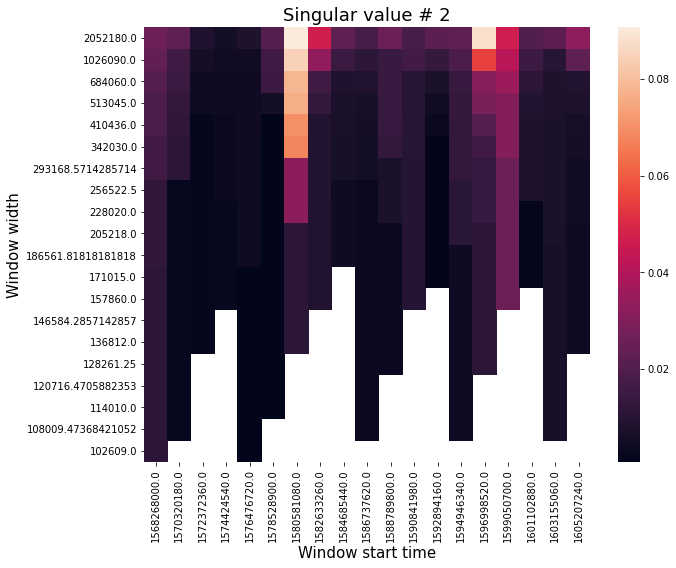

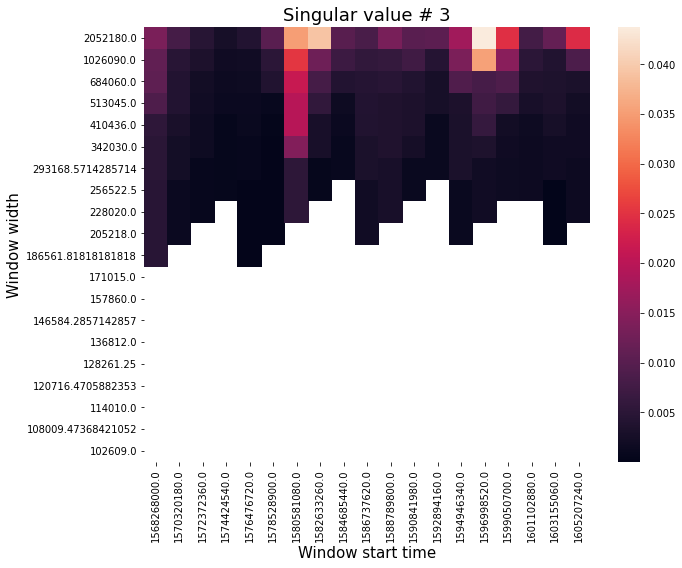

In [24]:
timeseries.plot_info_surface(cols=['baz', 'foo', 'bar']);

## Data quality checks

We have some tools for quickly checking the quality of a data feature intended for use as a basis. Whether missing or unevenely-spaced data is OK or problematic is 100% context dependent. (The isthmuslib sliding window analysis is robust and non-uniform data is fine. However for seasonal decomposition this is TBD).

### First we start with some complete and uniform data:

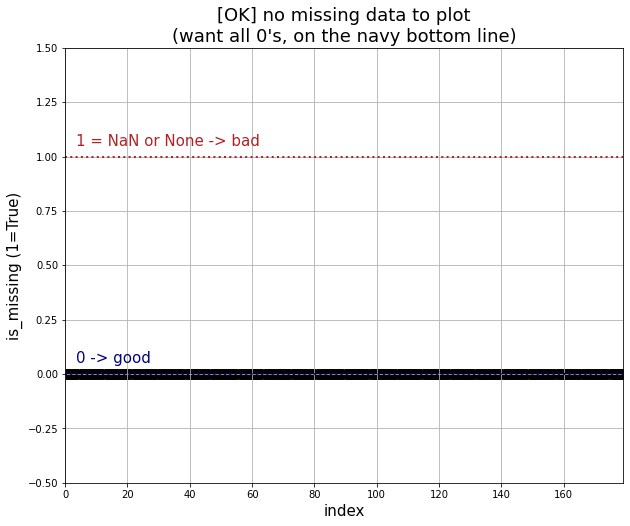

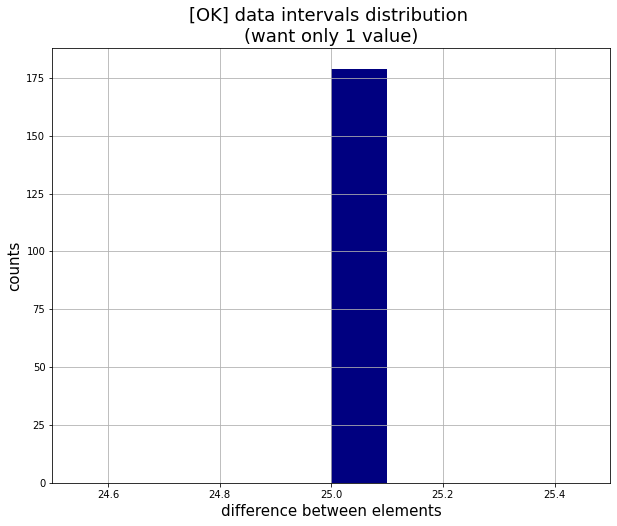

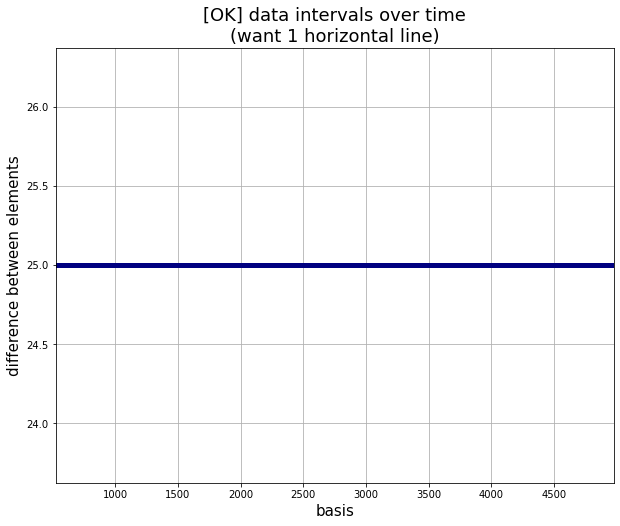

In [25]:
uniform_complete_data: List[int] = list(range(500, 5000, 25))
isli.basis_quality_plots(uniform_complete_data);

### Example with non-uniform spacing
The bottom two plots (color, title, shape) will warn us

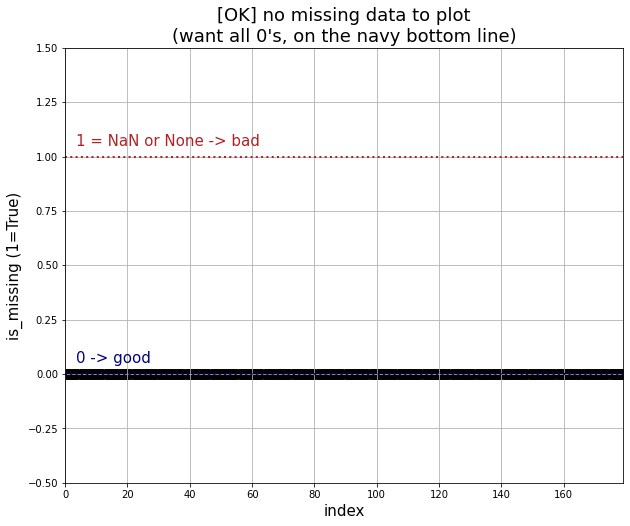

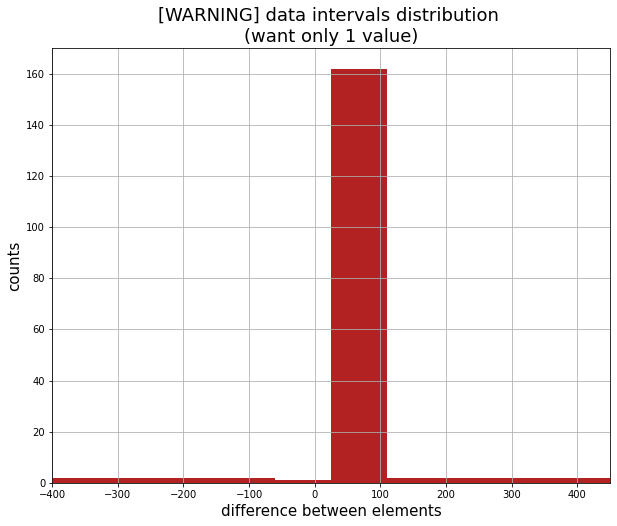

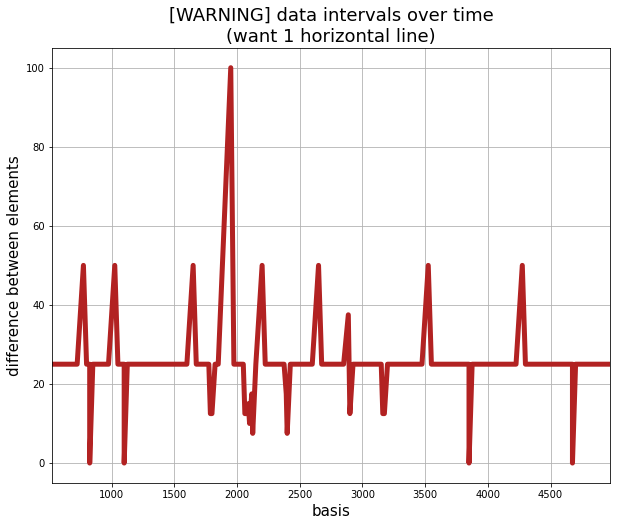

In [26]:
uneven_data = deepcopy(uniform_complete_data)
for index in [10, 20, 45, 55, 56, 57, 67, 85, 95, 120, 150]:
    uneven_data[index] *= 1.1
isli.basis_quality_plots(uneven_data);

### Example with `NaN`s, `None`s, etc
(Note that with missing data the differences cannot be calculated, so requested plots are returned but intentionally left blank)

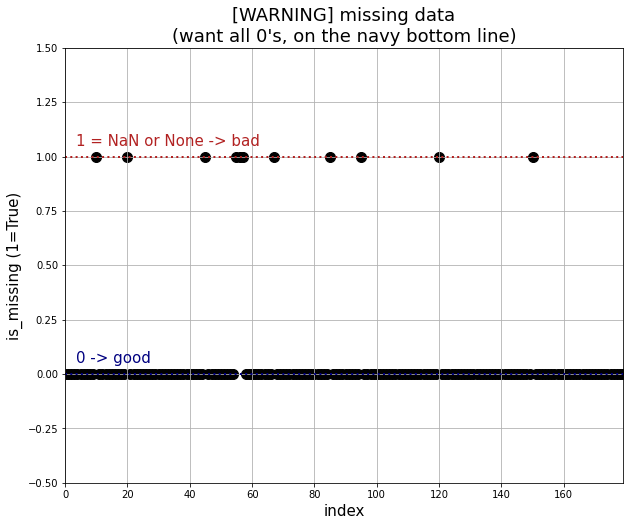

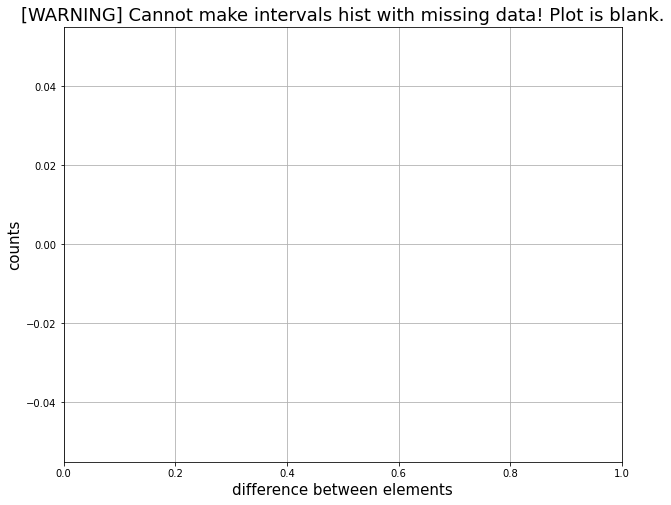

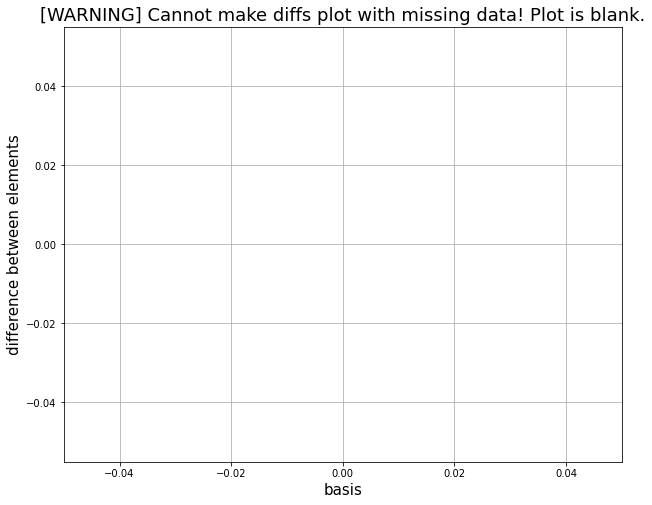

In [27]:
uneven_data = deepcopy(uniform_complete_data)
for index in [10, 20, 45, 55, 56, 57]:
    uneven_data[index] = None
for index in [67, 85, 95, 120, 150]:
    uneven_data[index] = np.nan
isli.basis_quality_plots(uneven_data);